# <font color='blue'>Strava Running Data Analysis: Performance Trends and Influencing Factors</font>

## Foreword

> “Pain is inevitable. Suffering is optional.”

A quote from one of the only books I had read about fitness. `"What I Talk About When I Talk About Running"` written by Haruki Murakami. I was curious what was a man like this doing in the fitness section. At that point I hadnt run a single yard more than what was required of me -- but by the time I finished reading, I was a changed man. 

I slowly built a habit of running from 2016, enjoyed the meditative aspect of it, ran often enough but never really got out of the proverbial shallow end of the pool. Its now 2024 and after many fun years of exploring other sports, I realized my base fitness was lacking. I had decided to pick up running sometime in May, for real this time. Now I've signed up for a half marathon in November, and I want to use what I know about data science to assist me.

## Abstract
In this notebook, we will dive in and analyze running data collected from my _**Strava**_ to identify performance trends and influencing factors. The analysis will not only provide insights into overall fitness progression but also inform on the factors that influence running performance as well as the distinct types of runs that are most common.

## Project steps
1. Source data from Strava Export. Download files from [Bulk Export](https://support.strava.com/hc/en-us/articles/216918437-Exporting-your-Data-and-Bulk-Export#h_01GG58HC4F1BGQ9PQZZVANN6WF) on my own profile menu.
2. Load, assess and clean the data for analysis.
3. Create any features that would provide additional insight for analysis.
4. Generate graphs and charts to illustrate insights.
5. Analyze with machine learning.

## Table of Contents
- [Accessing the data](#accessing_data);
- [Data Cleaning](#data_cleaning);
- [Feature Engineering](#feature_engineering);
- [Insights](#insights);
- [Feature Selection](#feature_selection);
- [Machine Learning](#machine_learning);
- [Conclusion](#conclusion);


In [1]:
#pandas and plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates 
import calendar 
from datetime import timedelta
from matplotlib.patches import FancyArrowPatch

# machine learning
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings('ignore')

# <font color='green'>Accessing the data</font><a class="anchor" id="accessing_data"></a>

In [2]:
# Load the data from an export on Strava
original = pd.read_csv('../Data/activities.csv') 
print('Dataframe shape:', original.shape)
original.head()

Dataframe shape: (254, 94)


,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,Activity Count,Total Steps,Carbon Saved,Pool Length,Training Load,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Media
0,676696158,"Aug 15, 2016, 9:53:13 AM",Afternoon Run,Run,NaN,1414,3.31,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,681425706,"Aug 19, 2016, 10:11:34 AM",Evening Run,Run,NaN,2062,4.45,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,683559635,"Aug 21, 2016, 10:14:46 AM",Evening Run,Run,NaN,1903,4.41,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,689475888,"Aug 26, 2016, 10:22:15 AM",Evening Run,Run,NaN,1920,4.51,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,708051143,"Sep 11, 2016, 9:19:10 AM",Afternoon Run,Run,NaN,1922,4.43,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### First observations:
There are a whopping 94 columns, most of which are either null or dont contribute to the analysis, so lets keep only the relevant columns for research

# <font color='green'>Data cleaning</font><a class="anchor" id="data_cleaning"></a>

In [3]:
original.columns = original.columns.str.lower().str.replace(' ','_') # Standardize the column titles
original = original[original['activity_type'] == 'Run'] # Filter to only Running values
df = original.copy(deep=True) # Make a copy so that there is always the original to reference to

In [4]:
print(df.shape)
df.head()

(217, 94)


,activity_id,activity_date,activity_name,activity_type,activity_description,elapsed_time,distance,max_heart_rate,relative_effort,commute,...,activity_count,total_steps,carbon_saved,pool_length,training_load,intensity,average_grade_adjusted_pace,timer_time,total_cycles,media
0,676696158,"Aug 15, 2016, 9:53:13 AM",Afternoon Run,Run,NaN,1414,3.31,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,681425706,"Aug 19, 2016, 10:11:34 AM",Evening Run,Run,NaN,2062,4.45,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,683559635,"Aug 21, 2016, 10:14:46 AM",Evening Run,Run,NaN,1903,4.41,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,689475888,"Aug 26, 2016, 10:22:15 AM",Evening Run,Run,NaN,1920,4.51,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,708051143,"Sep 11, 2016, 9:19:10 AM",Afternoon Run,Run,NaN,1922,4.43,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def list_nulls(df):
    null_df = [[col, df[col].isnull().sum()] for col in df.columns]
    print('Null Data:', df.isnull().sum().sum())
    print(list(filter(lambda x: x[1]>0, null_df)))

list_nulls(df)

Null Data: 14355
[['activity_description', 187], ['max_heart_rate', 160], ['relative_effort', 160], ['activity_private_note', 217], ['activity_gear', 168], ['athlete_weight', 92], ['bike_weight', 217], ['average_speed', 90], ['elevation_loss', 100], ['average_positive_grade', 217], ['average_negative_grade', 217], ['max_cadence', 217], ['average_cadence', 217], ['max_heart_rate.1', 170], ['average_heart_rate', 160], ['max_watts', 217], ['average_watts', 217], ['max_temperature', 217], ['average_temperature', 217], ['relative_effort.1', 160], ['total_work', 217], ['number_of_runs', 217], ['uphill_time', 217], ['downhill_time', 217], ['other_time', 217], ['perceived_exertion', 215], ['type', 217], ['start_time', 217], ['weighted_average_power', 217], ['power_count', 217], ['prefer_perceived_exertion', 185], ['perceived_relative_effort', 215], ['total_weight_lifted', 217], ['from_upload', 90], ['grade_adjusted_distance', 62], ['weather_observation_time', 190], ['weather_condition', 190], 

In [6]:
columns_keep = ['activity_date','moving_time','distance','max_speed','average_speed','elevation_gain','elevation_loss','elevation_low','elevation_high','max_grade','average_grade','max_heart_rate','average_heart_rate','total_steps']
df = df.loc[:,columns_keep]
print(df.shape)
df.head()

(217, 14)


,activity_date,moving_time,distance,max_speed,average_speed,elevation_gain,elevation_loss,elevation_low,elevation_high,max_grade,average_grade,max_heart_rate,average_heart_rate,total_steps
0,"Aug 15, 2016, 9:53:13 AM",1314.0,3.31,7.2,NaN,39.465000,NaN,53.200001,87.599998,16.200001,-0.241473,NaN,NaN,NaN
1,"Aug 19, 2016, 10:11:34 AM",1802.0,4.45,8.3,NaN,63.403999,NaN,50.299999,87.300003,40.200001,0.125682,NaN,NaN,NaN
2,"Aug 21, 2016, 10:14:46 AM",1898.0,4.41,5.5,NaN,51.626202,NaN,46.400002,87.699997,16.299999,-0.002268,NaN,NaN,NaN
3,"Aug 26, 2016, 10:22:15 AM",1900.0,4.51,5.7,NaN,119.328003,NaN,64.000000,137.699997,22.400000,0.026587,NaN,NaN,NaN
4,"Sep 11, 2016, 9:19:10 AM",1913.0,4.43,4.9,NaN,130.173996,NaN,64.000000,138.300003,23.500000,0.069921,NaN,NaN,NaN


In [7]:
df = df.dropna(axis=1,how='all') # Dropping all the rows with completely null rows
df.shape

(217, 14)

In [8]:
# Convert 'activity_date' to datetime
df['activity_date'] = pd.to_datetime(df['activity_date'])

In [9]:
df = df.drop(df[(df.distance < 1)].index) # Remove any runs under 1km, most likely misinputs or warmups
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(212, 14)


,activity_date,moving_time,distance,max_speed,average_speed,elevation_gain,elevation_loss,elevation_low,elevation_high,max_grade,average_grade,max_heart_rate,average_heart_rate,total_steps
0,2016-08-15 09:53:13,1314.0,3.31,7.2,NaN,39.465000,NaN,53.200001,87.599998,16.200001,-0.241473,NaN,NaN,NaN
1,2016-08-19 10:11:34,1802.0,4.45,8.3,NaN,63.403999,NaN,50.299999,87.300003,40.200001,0.125682,NaN,NaN,NaN
2,2016-08-21 10:14:46,1898.0,4.41,5.5,NaN,51.626202,NaN,46.400002,87.699997,16.299999,-0.002268,NaN,NaN,NaN
3,2016-08-26 10:22:15,1900.0,4.51,5.7,NaN,119.328003,NaN,64.000000,137.699997,22.400000,0.026587,NaN,NaN,NaN
4,2016-09-11 09:19:10,1913.0,4.43,4.9,NaN,130.173996,NaN,64.000000,138.300003,23.500000,0.069921,NaN,NaN,NaN


In [10]:
# Check for nulls again, consider any imputes or further drops
list_nulls(df)

Null Data: 665
[['average_speed', 90], ['elevation_loss', 100], ['max_heart_rate', 160], ['average_heart_rate', 160], ['total_steps', 155]]


# <font color='green'>Feature engineering</font><a class="anchor" id="feature_engineering"></a>

In [11]:
# Create year and month columns
df['year'] = df['activity_date'].dt.year
df['month'] = df['activity_date'].dt.month

#Convert the speeds into a more familiar metric which is minutes/km
df['moving_time_minutes'] = round(df['moving_time']/60, 2)
df['distance'] = round(df['distance'], 2) # Since its already in km, no need for any conversion
df['pace'] = round(df['moving_time_minutes'] / df['distance'],2)
df['max_pace'] = round(1000/df['max_speed'] / 60,2)
df = df.drop(columns=['average_speed','max_speed'])

# Add some useful date & time features
df['week'] = df['activity_date'].dt.to_period('W')
df['start_date'] = df['activity_date'].dt.date
df['start_time'] = df['activity_date'].dt.time
df['week_start_date'] = df.week.apply(lambda r: r.start_time.date())
df['weekday'] = df['activity_date'].apply(lambda x: x.weekday())
df.head()

,activity_date,moving_time,distance,elevation_gain,elevation_loss,elevation_low,elevation_high,max_grade,average_grade,max_heart_rate,...,year,month,moving_time_minutes,pace,max_pace,week,start_date,start_time,week_start_date,weekday
0,2016-08-15 09:53:13,1314.0,3.31,39.465000,NaN,53.200001,87.599998,16.200001,-0.241473,NaN,...,2016,8,21.90,6.62,2.31,2016-08-15/2016-08-21,2016-08-15,09:53:13,2016-08-15,0
1,2016-08-19 10:11:34,1802.0,4.45,63.403999,NaN,50.299999,87.300003,40.200001,0.125682,NaN,...,2016,8,30.03,6.75,2.01,2016-08-15/2016-08-21,2016-08-19,10:11:34,2016-08-15,4
2,2016-08-21 10:14:46,1898.0,4.41,51.626202,NaN,46.400002,87.699997,16.299999,-0.002268,NaN,...,2016,8,31.63,7.17,3.03,2016-08-15/2016-08-21,2016-08-21,10:14:46,2016-08-15,6
3,2016-08-26 10:22:15,1900.0,4.51,119.328003,NaN,64.000000,137.699997,22.400000,0.026587,NaN,...,2016,8,31.67,7.02,2.92,2016-08-22/2016-08-28,2016-08-26,10:22:15,2016-08-22,4
4,2016-09-11 09:19:10,1913.0,4.43,130.173996,NaN,64.000000,138.300003,23.500000,0.069921,NaN,...,2016,9,31.88,7.20,3.40,2016-09-05/2016-09-11,2016-09-11,09:19:10,2016-09-05,6


### <font color='red'>--Excess of nulls in the columns Elevation loss, Max Heart Rate, Average Heart Rate and Total Steps--</font>

Besides pace, I suspect the other nulls are due to the fact that majority of my runs were run **before** I bought a fitness tracker watch. Unfortunately, will have to drop them. 

But instead of dropping the columns, I will instead _**filter the dataframe**_ to the time I started training in 2024, which should have a complete set of data.

In [12]:
latest_df = df[df.activity_date > '2024-04-01']
list_nulls(latest_df)
print(latest_df.shape)
latest_df.head()

Null Data: 2
[['max_heart_rate', 1], ['average_heart_rate', 1]]
(43, 22)


,activity_date,moving_time,distance,elevation_gain,elevation_loss,elevation_low,elevation_high,max_grade,average_grade,max_heart_rate,...,year,month,moving_time_minutes,pace,max_pace,week,start_date,start_time,week_start_date,weekday
169,2024-04-23 03:41:19,1005.0,1.36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,186.0,...,2024,4,16.75,12.32,6.01,2024-04-22/2024-04-28,2024-04-23,03:41:19,2024-04-22,1
170,2024-04-24 00:04:13,2312.0,4.05,168.199997,166.199997,36.400002,104.599998,48.522873,0.049375,174.0,...,2024,4,38.53,9.51,4.48,2024-04-22/2024-04-28,2024-04-24,00:04:13,2024-04-22,2
171,2024-04-25 01:15:43,1117.0,1.35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,175.0,...,2024,4,18.62,13.79,5.36,2024-04-22/2024-04-28,2024-04-25,01:15:43,2024-04-22,3
172,2024-05-01 08:12:56,2280.0,4.07,278.000000,282.799988,72.199997,126.599998,49.813019,-0.117833,174.0,...,2024,5,38.00,9.34,3.95,2024-04-29/2024-05-05,2024-05-01,08:12:56,2024-04-29,2
173,2024-04-29 03:30:40,1963.0,2.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,183.0,...,2024,4,32.72,16.28,6.56,2024-04-29/2024-05-05,2024-04-29,03:30:40,2024-04-29,0


In [13]:
# Impute the remaining missing data with the averages
latest_df['average_heart_rate'] = latest_df['average_heart_rate'].fillna(value=latest_df['average_heart_rate'].mean())
latest_df['max_heart_rate'] = latest_df['max_heart_rate'].fillna(value=latest_df['max_heart_rate'].mean())
list_nulls(latest_df)

Null Data: 0
[]


In [14]:
zero_rows = latest_df[(latest_df == 0).any(axis=1)]
print(zero_rows.shape)
zero_rows

(8, 22)


,activity_date,moving_time,distance,elevation_gain,elevation_loss,elevation_low,elevation_high,max_grade,average_grade,max_heart_rate,...,year,month,moving_time_minutes,pace,max_pace,week,start_date,start_time,week_start_date,weekday
169,2024-04-23 03:41:19,1005.0,1.36,0.0,0.000000,0.0,0.000000,0.000000,0.000000,186.0,...,2024,4,16.75,12.32,6.01,2024-04-22/2024-04-28,2024-04-23,03:41:19,2024-04-22,1
171,2024-04-25 01:15:43,1117.0,1.35,0.0,0.000000,0.0,0.000000,0.000000,0.000000,175.0,...,2024,4,18.62,13.79,5.36,2024-04-22/2024-04-28,2024-04-25,01:15:43,2024-04-22,3
173,2024-04-29 03:30:40,1963.0,2.01,0.0,0.000000,0.0,0.000000,0.000000,0.000000,183.0,...,2024,4,32.72,16.28,6.56,2024-04-29/2024-05-05,2024-04-29,03:30:40,2024-04-29,0
175,2024-05-07 02:21:57,1714.0,3.28,0.0,0.000000,0.0,0.000000,0.000000,0.000000,189.0,...,2024,5,28.57,8.71,6.46,2024-05-06/2024-05-12,2024-05-07,02:21:57,2024-05-06,1
176,2024-05-08 03:55:46,2147.0,2.09,0.0,0.000000,0.0,0.000000,0.000000,0.000000,190.0,...,2024,5,35.78,17.12,6.66,2024-05-06/2024-05-12,2024-05-08,03:55:46,2024-05-06,2
184,2024-06-24 22:34:25,2023.0,3.87,200.0,219.800003,15.6,85.000000,48.284103,-0.517903,168.0,...,2024,6,33.72,8.71,3.79,2024-06-24/2024-06-30,2024-06-24,22:34:25,2024-06-24,0
199,2024-07-24 14:49:33,1086.0,2.24,0.0,0.000000,0.0,0.000000,0.000000,0.000000,180.0,...,2024,7,18.10,8.08,6.35,2024-07-22/2024-07-28,2024-07-24,14:49:33,2024-07-22,2
206,2024-08-05 23:19:57,1254.0,2.18,143.0,140.000000,16.4,63.200001,48.390980,0.099630,153.0,...,2024,8,20.90,9.59,4.88,2024-08-05/2024-08-11,2024-08-05,23:19:57,2024-08-05,0


### <font color='red'>--Zero values in many elevation metrics--</font>

With a total of 6 rows containing 0 elevation data, it is worth considering dropping these rows.

Checking on actual strava, I found that these were manual uploads that did not upload properly. Will drop these.

In [15]:
latest_df = latest_df.drop(zero_rows.index)
latest_df.shape

(35, 22)

In [16]:
latest_df.head()

,activity_date,moving_time,distance,elevation_gain,elevation_loss,elevation_low,elevation_high,max_grade,average_grade,max_heart_rate,...,year,month,moving_time_minutes,pace,max_pace,week,start_date,start_time,week_start_date,weekday
170,2024-04-24 00:04:13,2312.0,4.05,168.199997,166.199997,36.400002,104.599998,48.522873,0.049375,174.0,...,2024,4,38.53,9.51,4.48,2024-04-22/2024-04-28,2024-04-24,00:04:13,2024-04-22,2
172,2024-05-01 08:12:56,2280.0,4.07,278.000000,282.799988,72.199997,126.599998,49.813019,-0.117833,174.0,...,2024,5,38.00,9.34,3.95,2024-04-29/2024-05-05,2024-05-01,08:12:56,2024-04-29,2
174,2024-05-04 09:41:57,2359.0,5.01,193.399994,164.600006,-1.600000,37.799999,49.948692,0.570642,182.0,...,2024,5,39.32,7.85,1.23,2024-04-29/2024-05-05,2024-05-04,09:41:57,2024-04-29,5
177,2024-05-17 22:25:45,1937.0,3.40,166.400024,166.399994,442.399994,481.600006,48.871666,0.047297,166.0,...,2024,5,32.28,9.49,4.27,2024-05-13/2024-05-19,2024-05-17,22:25:45,2024-05-13,4
178,2024-05-18 23:22:30,8935.0,14.81,992.799927,1008.799988,395.200012,523.000000,49.956367,-0.156001,202.0,...,2024,5,148.92,10.06,4.98,2024-05-13/2024-05-19,2024-05-18,23:22:30,2024-05-13,5


# <font color='green'>Insights</font><a class="anchor" id="insights"></a>

Now we will be exploring some insights using data visualization. 

**Note**: pace is in minutes/km, therefore the *lower* the y-value, the *faster* it is. So `lower=better`.

Text(0.5, 1.0, 'Max pace vs distance')

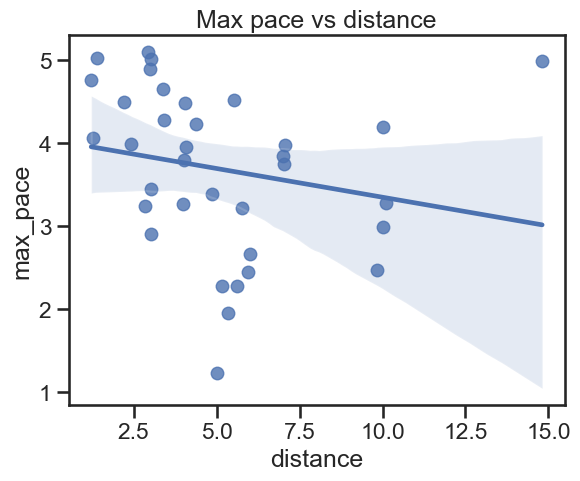

In [17]:
sns.set(style='ticks',context='talk')
sns.regplot(x='distance',y='max_pace',data=latest_df).set_title('Max pace vs distance')

Text(0.5, 1.0, 'Pace vs distance')

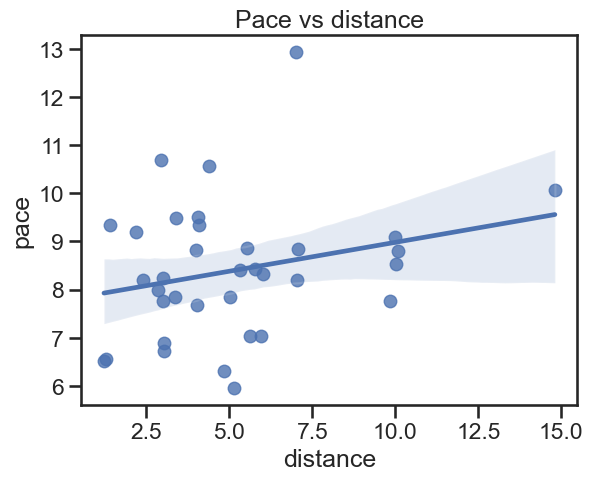

In [18]:
sns.set(style='ticks',context='talk')
sns.regplot(x='distance',y='pace',data=latest_df).set_title('Pace vs distance')

### <font color='orange'>Pace & Max Pace VS Distance</font>

These charts show running pace vs distance. The max pace tends to decrease slightly over longer distances, which is normal. Overall pace also slows a bit with distance, but not dramatically. There's significant variation in both max and average pace across runs, suggesting factors beyond distance (like terrain or conditions) strongly influence your speed.  There is relative consistency in pacing across distances, which could be a strength. The outlier slow pace on a medium-distance run might be worth investigating. In general, these charts indicate distance affects your pace, but other factors play a big role too.

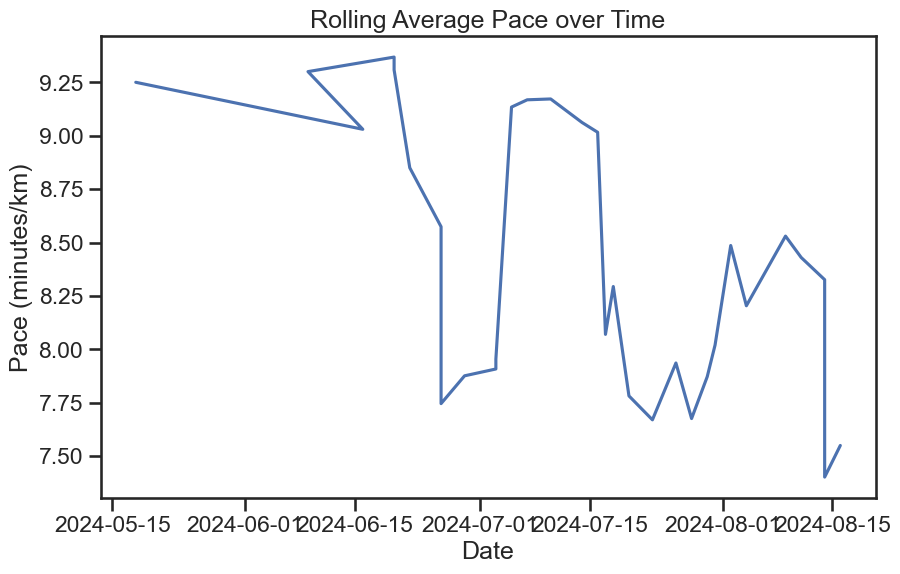

In [19]:

# Calculate rolling average pace to smooth out variations
rolling = latest_df.pace.rolling(window=5).mean()

plt.figure(figsize=(10, 6))
plt.plot(latest_df.start_date, rolling)
plt.title('Rolling Average Pace over Time')
plt.xlabel('Date')
plt.ylabel('Pace (minutes/km)')
plt.show()

### <font color='orange'> Rolling Average Insights</font>

The data exhibits a recurring pattern of sharp performance improvements followed by notable pace increases, likely indicative of intense training phases succeeded by recovery periods. Significantly, this cyclical pattern demonstrates a gradual attenuation over time, suggesting:

- Enhanced recovery efficiency
- Improved baseline fitness
- Potential optimization of the training-recovery balance

This trend points towards a maturing and increasingly effective training regimen, where the performance gains more consistently while potentially reducing the physiological stress of intense training phases.

In [20]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)
        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]
        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3])

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0], bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                dir_vec = self.com - self.bubbles[i, :2]
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        new_point1 = self.bubbles[i, :2] + orth * self.step_dist
                        new_point2 = self.bubbles[i, :2] - orth * self.step_dist
                        dist1 = self.center_distance(self.com, np.array([new_point1]))
                        dist2 = self.center_distance(self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()
            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, data, colors):
        for i, (year, total, avg) in enumerate(data):
            bubble = self.bubbles[i]
            
            # Create the bubble
            circ = plt.Circle(bubble[:2], bubble[2], color=colors[i], alpha=0.7)
            ax.add_patch(circ)
            
            # Add year in the center
            ax.text(*bubble[:2], str(year),
                    horizontalalignment='center', verticalalignment='center',
                    color='black', fontname='Arial', fontsize=12, fontweight='bold')
            
            # Add single arrow with both annotations
            self._add_annotations(ax, bubble, total, avg)

    def _add_annotations(self, ax, bubble, total, avg):
        radius = bubble[2]
        angle = 45  # You can adjust this angle as needed
        
        # Calculate the position for the arrow and text
        arrow_x = bubble[0] + np.cos(np.radians(angle)) * radius * 0.7
        arrow_y = bubble[1] + np.sin(np.radians(angle)) * radius * 0.7
        
        text_x = arrow_x + np.cos(np.radians(angle)) # * radius * 0.5
        text_y = arrow_y + np.sin(np.radians(angle)) # * radius * 0.5
        
        # Create the arrow
        ax.annotate('', xy=(bubble[0] + 0.5, bubble[1] + 0.5), xytext=(arrow_x, arrow_y),
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='black'))
        
        # Add the text annotations
        ax.text(text_x, text_y, f"Total: {total:.0f} km\nAvg: {avg:.2f} km",
                horizontalalignment='left', verticalalignment='center',
                color='black', fontname='Arial', fontsize=8,
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7, pad=4))

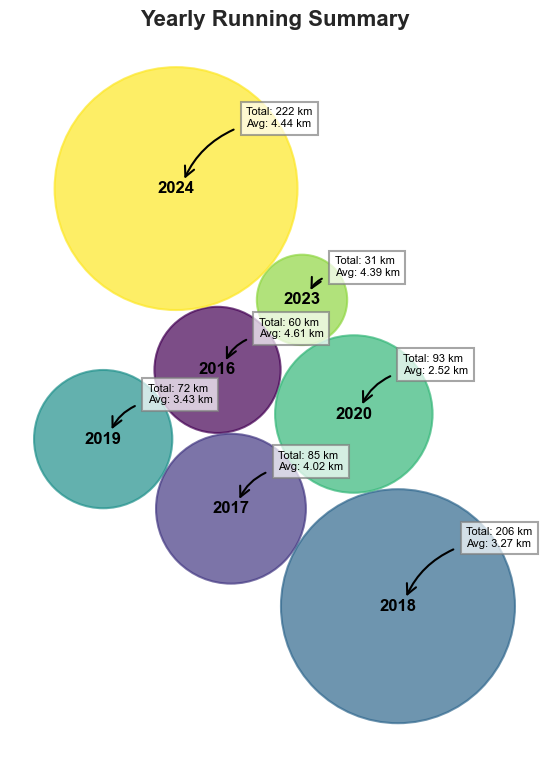

In [21]:
# Prepare data for bubble chart
yearly_stats = df.groupby('year').agg({
    'distance': ['sum', 'mean', 'count']
}).reset_index()
yearly_stats.columns = ['year', 'total_distance', 'avg_distance', 'run_count']

# Create bubble chart
bubble_chart = BubbleChart(area=yearly_stats['total_distance'], bubble_spacing=0.1)
bubble_chart.collapse()

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

# Generate colors
num_years = len(yearly_stats)
colors = plt.cm.viridis(np.linspace(0, 1, num_years))

# Prepare data for plotting
plot_data = list(zip(yearly_stats['year'], 
                     yearly_stats['total_distance'], 
                     yearly_stats['avg_distance']))

# Plot the bubble chart
bubble_chart.plot(ax, plot_data, colors)

    # Customize the plot
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Yearly Running Summary', fontsize=16, fontweight='bold', fontname='Arial')

plt.tight_layout()
plt.show()

### <font color='orange'>Yearly Running Summary Insights</font>

From 2016 to 2018 there was an obvious gradual increase in volume however, 2019/2020 showed a drastic reduction and completely missing from 2021/2022. This is likely due to **COVID-19 Pandemic** and has inadvertedly affected fitness overall.

In [22]:
latest_df.weekday.value_counts() 

# I really have never ran a monday in 8 weeks lol, I can safely say this is because Sundays are long run days so naturally
# Mondays are not really an option

weekday
2    11
6     7
4     6
5     5
3     3
1     3
Name: count, dtype: int64

In [23]:
# First, let's create a mapping of weekday numbers to names
weekday_names = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

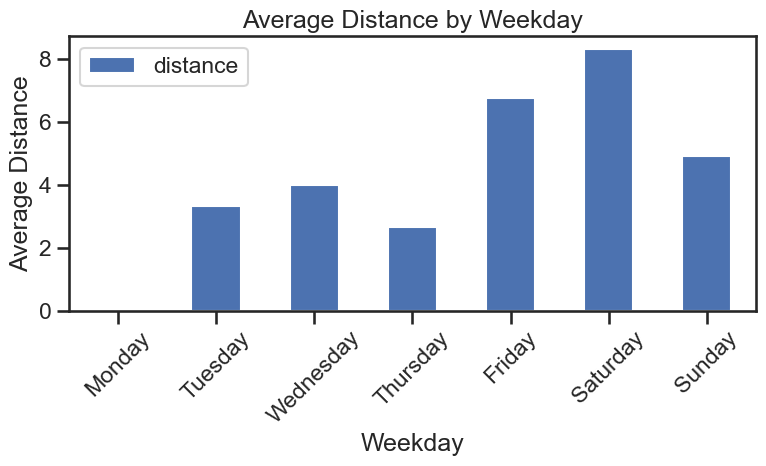

In [24]:
# Calculate the mean moving time for each weekday
result = latest_df.groupby('weekday').agg({
    'distance': 'mean'
}).reindex(range(7))  # This ensures all weekdays are included

# Rename the index with weekday names
result.index = result.index.map(weekday_names)

# Plot the results
ax = result.plot(kind='bar', figsize=(8, 5))
plt.title('Average Distance by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### <font color='orange'>Average Distance by Weekday Insights</font>

Weekends (and fridays) are typically when I have the most freedom to run long distances since the availability for training is greater, whichalso  contributes to most of the weekly volume.

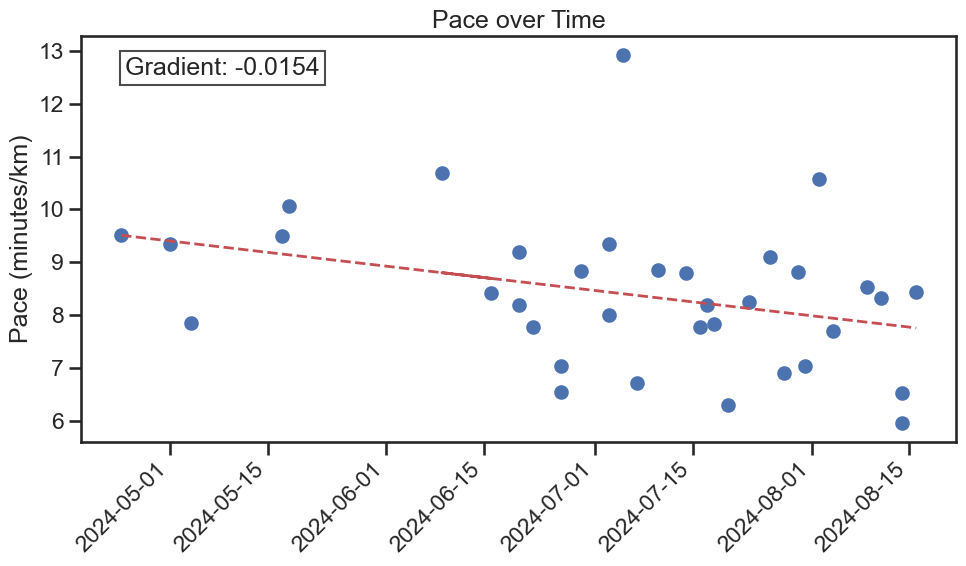

In [25]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)

x = np.asarray(latest_df.start_date)
y = np.asarray(latest_df.pace)

ax1.scatter(x, y)
ax1.set_title('Pace over Time')

x2 = mdates.date2num(x)
z = np.polyfit(x2, y, 1)
p = np.poly1d(z)

# Extract the gradient (slope)
gradient = z[0]

plt.plot(x, p(x2), 'r--', linewidth=2)

# Add gradient text to the plot
ax1.text(0.05, 0.95, f'Gradient: {gradient:.4f}', 
         transform=ax1.transAxes, verticalalignment='top',bbox=dict(facecolor='white',edgecolor='black',alpha=0.7))

ax1.set_ylabel('Pace (minutes/km)')
# ax1.legend()

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.show()

### <font color='orange'> Pace over Time Insights </font>
The graph depics a slight overall improvement in speed (lower pace) despite day-to-day variations. In my case, its worth mentioning that this is the result of training and all the effort dedicated to the sport.

# <font color='green'>Feature Selection</font><a class="anchor" id="feature_selection"></a>
This is an important step for the application of machine learning models later. This way we can confirm whether the empirically cited characteristics are really good.

The first way to understand the features and how they interact with the response variable is through the `correlation matrix`.

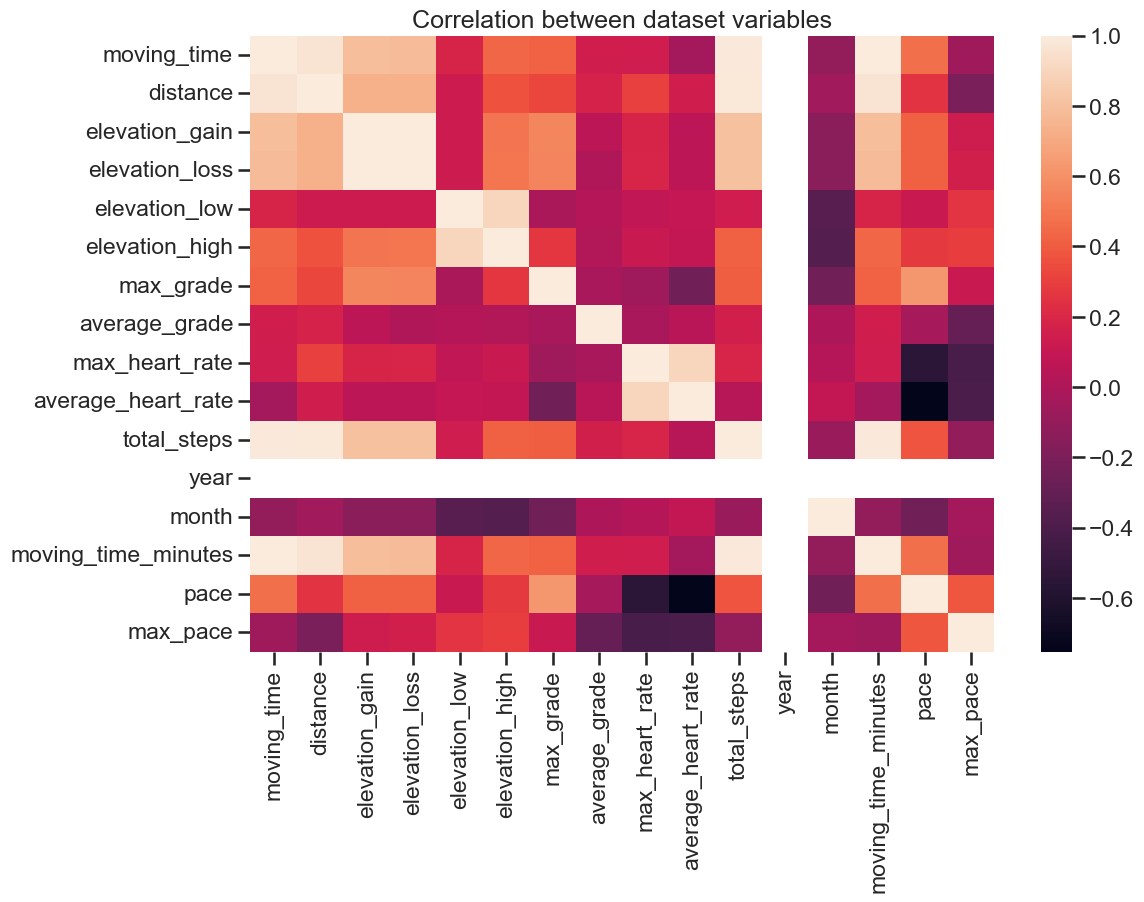

In [26]:
numerical_cols = latest_df.select_dtypes(include=['float64','int32'])

corr = numerical_cols.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, fmt=".2f");
plt.title('Correlation between dataset variables')
plt.show()

### <font color='orange'>Matrix Analysis</font>
From this matrix, it can be defined that the values closest to +1 have a positive correlation and the values closest to -1 have a negative correlation.

To continue with the analyses, the running dataframe will be scrambled so that problems related to bias and dataframe sequence learning are prevented.

In [32]:
def get_best_rfe_features(X,y, model):
    rfe = RFE(model, step=0.05).fit(X, y)
    selected_features = [i for i, j in zip(X.columns, rfe.support_) if j]
    return selected_features
    
runs = numerical_cols.sample(frac=1).reset_index(drop=True) 
# list_nulls(runs)

y = runs['pace']
X = runs.drop('pace',axis=1)

encoded_y = preprocessing.LabelEncoder().fit_transform(y)
model = LinearRegression()
linear_feats = get_best_rfe_features(X, encoded_y, model)
linear_feats


['distance',
 'elevation_loss',
 'average_grade',
 'average_heart_rate',
 'month',
 'moving_time_minutes',
 'max_pace']

### <font color='orange'> Recursive Feature Elimination </font>
The above code will train the RFE model and recursively elimate features acoording to their lack of importance.

Finally `linear_feats` then are the best variables selected for regression

# <font color='green'>Machine Learning</font><a class='anchor' id='machine_learning'></a>
I will only be using 1 machine learning techniques, among the many available, which is `Clustering`. This is because I have no need for regression to predict when I can easily calculate the pace/distance with the right metrics. It is more important to me what kinds of run im having and the kinds of heart rate I should be aiming for.


### Clustering
I will be performing a technique called K-means. This technique will group records of races that are similar. Note that the method is stochastic, so each execution will likely generate different results.

In [28]:
X = runs.drop('pace',axis=1)
X = pd.get_dummies(X)

model = KMeans(n_clusters=4).fit(X)
clustering_runs = runs.copy()
clustering_runs['Cluster'] = model.labels_

In [29]:
clustering_runs['Cluster'].value_counts()

Cluster
2    16
0    12
1     6
3     1
Name: count, dtype: int64

In [30]:
clustering_runs.groupby('Cluster').mean()

,moving_time,distance,elevation_gain,elevation_loss,elevation_low,elevation_high,max_grade,average_grade,max_heart_rate,average_heart_rate,total_steps,year,month,moving_time_minutes,pace,max_pace
Cluster,,,,,,,,,,,,,,,,
0,1195.166667,2.474167,63.215174,67.928377,42.825000,67.708333,31.144058,-0.246359,177.333333,162.641992,3004.833333,2024.0,6.750000,19.919167,7.996667,4.294167
1,4947.000000,9.001667,404.646746,403.980249,-16.466667,76.350000,46.251586,0.028638,175.273810,156.252586,11943.000000,2024.0,6.833333,82.450000,9.328333,3.453333
2,2449.437500,5.008750,177.150003,175.712498,53.287499,103.237501,37.202141,0.035288,182.437500,165.680799,6201.375000,2024.0,6.625000,40.824375,8.238125,3.228750
3,8935.000000,14.810000,992.799927,1008.799988,395.200012,523.000000,49.956367,-0.156001,202.000000,181.586426,20382.000000,2024.0,5.000000,148.920000,10.060000,4.980000


## <font color='orange'>Cluster Overview</font>
There are 4 distinct clusters, each representing a different type of run or running patern

### Clusting Characteristics
*Cluster A: **Moderate** Runs*
- Average distance: ~5km
- Moderate elevation gain
- Higher heart rates
- Representing typical training runs (also the highest sample among the clusters)

*Cluster B: **Long** Runs*
- Average distance: ~9km
- Higher elevation gain
- Lower average heart rate than Moderate Run (likely due to long runs being used for slower, volume jogs)
- Endurance building runs

*Cluster C: **Short** Runs*
- Average distance: ~2.5km
- Lowest elevation gain, flattest ground
- Higher pace than the rest
- Heart rate roughly matching Cluster 0 even with less distance
- Representing speed sessions and/or training sessions

*Cluster D: **Challenging** Long Runs*
- Average distance: ~15km
- Highest elevation gain
- Highest heart rate
- Outlier, representing races and trail runs

### Interesting Observations:
#### Run distance
The longer runs(Cluster 1) have lower average heart rate than shorter runs (Cluster 2), suggesting better cardiovascular efficiency on longer distances.
#### Elevation vs Pace
Clusters with higher elevation gain/loss (1 and 3) have slower paces, showing the impact of terrain on speed.

### Potential Insights:
_Training Variety_: A good mix of run types, from short, intense sessions to longer endurance runs.
_Heart Rate Zones_: Heart rate varies predictably with run intensity and distance.
_Terrain Impact_: There's a clear relationship between elevation changes and pace/effort.


## <font color='orange'>Calculate the race!
Now to conclude this study, lets predict how long it would take for me to run a 21KM run this November. 

Lets try and compare 2 ways of calculating, </br>

1. one by (naively) looking at the gradient of improvement over the past 8 weeks </br>
vs</br>
2. one by looking at the rolling average as well as extra weightage on longer runs</br>

### <font color='red'>--Gradient--</font>

In [46]:
# Calculate the improvement rate
days = (latest_df.start_date.max() - latest_df.start_date.min()).days
improvement_rate = gradient * days  # Improvement in minutes/km over the entire period

# Project future performance
target_pace = 6.0  # 2:06:00 for a half marathon is about 6 min/km
# Get the most recent date
most_recent_date = latest_df['week_start_date'].max()

# Calculate the date two weeks ago
two_weeks_ago = most_recent_date - timedelta(weeks=2)

# Filter the DataFrame for the last two weeks
last_two_weeks_df = latest_df[latest_df['week_start_date'] > two_weeks_ago]

# Get the highest pace from the last two weeks
current_pace = last_two_weeks_df['pace'].mean()
time_to_target = (current_pace - target_pace) / (-gradient)

def days_to_months_days(total_days):
    average_days_per_month = 30
    
    # Calculate the number of months
    months = int(total_days // average_days_per_month)
    
    # Calculate the remaining days
    remaining_days = int(total_days % average_days_per_month)
    
    return months,remaining_days

months,days = days_to_months_days(time_to_target)


print(f"Current pace: {current_pace:.2f} min/km")
print(f"Improvement rate: {-gradient*365:.2f} min/km per year")
print(f"Estimated days to reach target pace: {time_to_target:.0f}")
print(f"Estimated months and days to reach target pace: {months} months, {days:.0f} days")


Current pace: 7.55 min/km
Improvement rate: 5.62 min/km per year
Estimated days to reach target pace: 101
Estimated months and days to reach target pace: 3 months, 10 days


### <font color='red'>--Rolling Average--</font>

In [45]:
def predict_time_to_goal_pace(df, goal_pace, weeks_for_average=4, long_run_threshold=10, long_run_weight=1.5):
    # Sort the dataframe by date
    df = df.sort_values('activity_date')
    
    # Weight long runs more heavily
    weighted_pace = pd.Series(np.where(df['distance'] >= long_run_threshold, 
                                   df['pace'] * long_run_weight, 
                                   df['pace']))
    
    # Calculate weighted rolling average
    weighted_rolling_avg = weighted_pace.rolling(window=7*weeks_for_average, min_periods=1).mean()
    
    # Calculate the rate of improvement (pace decrease per day)
    days = (df['activity_date'] - df['activity_date'].min()).dt.days
    improvement_rate = np.polyfit(days, weighted_rolling_avg, 1)[0]
    
    # Get the most recent weighted rolling average
    current_weighted_avg = weighted_rolling_avg.iloc[-1]
    
    # Estimate current half marathon pace (typically 5-10% slower than average training pace)
    current_hm_pace = current_weighted_avg * 1.07  # Assuming 7% here
    
    # Calculate time to reach goal pace
    time_to_goal = (current_hm_pace - goal_pace) / (-improvement_rate)
    
    return current_hm_pace, improvement_rate, time_to_goal

# Example usage
goal_pace = 6.0  # min/km
current_pace, improvement_rate, days_to_goal = predict_time_to_goal_pace(latest_df, goal_pace)

print(f"Current estimated Half Marathon Pace: {current_pace:.2f} min/km")
print(f"Current improvement rate: {-improvement_rate*365:.4f} min/km per year")
print(f"Estimated days to reach goal pace: {days_to_goal:.0f}")

# Convert days to months and remaining days
months = int(days_to_goal // 30)
remaining_days = int(days_to_goal % 30)
print(f"Estimated time to reach goal pace: {months} months and {remaining_days} days")

Current estimated Half Marathon Pace: 9.24 min/km
Current improvement rate: 2.5660 min/km per year
Estimated days to reach goal pace: 460
Estimated time to reach goal pace: 15 months and 10 days


# <font color='purple'> Conclusion </font>
<a class="anchor" id="conclusion"></a>

The comparison of two prediction methods for the upcoming 21KM run in November reveals significantly different outcomes. The **gradient** method, a simpler approach, suggests a current pace of <font color='red'>7.55 min/km</font> and predicts reaching your goal in about 3 months. This method paints an **optimistic picture of rapid improvement**.

In contrast, the **rolling average method**, which factors in longer runs, estimates a slower current pace of <font color='red'>9.24 min/km</font> and projects a longer timeframe of 15 months to reach your goal. This approach likely provides a more realistic prediction, **accounting for the challenges of maintaining pace over longer distances**.

For the November race, it's prudent to base expectations on the more conservative rolling average estimate while working to exceed it. This balances optimism with realism, setting myself up for a potentially satisfying performance without risking disappointment from overly ambitious goals.

Thanks for reading!
